# Project 2 Part 6: Review Classification

### Load the Data

Load the joblib containing the data frame from Part 5 of the project.

Drop any reviews that do not have a rating.

Use the original review column as your X and the classification target (High/Low Rating Reviews) as your y.

### Build a Machine Learning Model

Build a sklearn modeling pipeline with a text vectorizer and a classification model.

Suggested Models: MultinomialNB, LogisticRegression (you may need to increase max_iter), RandomForestClassifier
Fit and evaluate the model using the machine learning classification models from sklearn.

In a Markdown cell, document your observations from your results. (e.g., how good is the model overall? Is it particularly good/bad at predicting one class?)

## Imports

In [108]:
# packages
import pandas as pd
import joblib
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers

In [119]:
# functions


def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict

def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])
    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()
    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):
        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]
        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass
        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)
    # Adjust subplots and show
    fig.tight_layout()
    plt.show()

def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs

def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

#### Load Part 5 joblib

In [4]:
# load joblib
df = joblib.load('Data-NLP/df-proj-2-part-5.joblib')

In [5]:
# preview df
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating,high_low,review_lowercase,tokens,spacy_lemmas,lemmas_joined,neg,neu,pos,compound
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,This is a fine piece of cinema from Wong Kar-W...,7.0,med,this is a fine piece of cinema from wong kar-w...,"[this, is, a, fine, piece, of, cinema, from, w...","[fine, piece, cinema, wong, kar, wai, tell, st...",fine piece cinema wong kar wai tell story peop...,0.068,0.744,0.188,0.9908
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,high,"a guilty pleasure for me personally, as i love...","[a, guilty, pleasure, for, me, personally,, as...","[guilty, pleasure, personally, love, great, es...",guilty pleasure personally love great escape w...,0.053,0.587,0.360,0.9450
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,Made my roommate who hates stop-motion animati...,6.0,med,made my roommate who hates stop-motion animati...,"[made, my, roommate, who, hates, stop-motion, ...","[roommate, hate, stop, motion, animation, watc...",roommate hate stop motion animation watch 2018...,0.071,0.776,0.153,0.7006
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,A very good stop-motion animation!\r\n\r\n<em>...,8.0,med,a very good stop-motion animation!\r\n\r\n<em>...,"[a, very, good, stop-motion, animation!, <em>'...","[good, stop, motion, animation, <, em>'chicken...",good stop motion animation < em>'chicken run'<...,0.039,0.637,0.325,0.9944
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this...",7.0,med,"ok, there is an huge temptation to riddle this...","[ok,, there, is, an, huge, temptation, to, rid...","[ok, huge, temptation, riddle, review, pun, go...",ok huge temptation riddle review pun go crack ...,0.056,0.699,0.245,0.9943


#### Drop any reviews that do not have a rating.

In [17]:
# drop any rows with na in rating column
df = df.dropna(subset=['rating'])

In [26]:
# drop rows with 'med' rating
df = df[df.high_low != 'med']

In [27]:
# verify changes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2419 entries, 1 to 8647
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review_id         2419 non-null   object 
 1   movie_id          2419 non-null   int64  
 2   imdb_id           2419 non-null   object 
 3   original_title    2419 non-null   object 
 4   review            2419 non-null   object 
 5   rating            2419 non-null   float64
 6   high_low          2419 non-null   object 
 7   review_lowercase  2419 non-null   object 
 8   tokens            2419 non-null   object 
 9   spacy_lemmas      2419 non-null   object 
 10  lemmas_joined     2419 non-null   object 
 11  neg               2419 non-null   float64
 12  neu               2419 non-null   float64
 13  pos               2419 non-null   float64
 14  compound          2419 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 302.4+ KB


#### Use the original review column as your X and the classification target (High/Low Rating Reviews) as your y.

In [28]:
# assign X and y
X = df['review']
y = df['high_low']

In [37]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,
                                                    random_state=42)

## Build a Machine Learning Model

### Build a sklearn modeling pipeline with a text vectorizer and a classification model.

Suggested Models: MultinomialNB, LogisticRegression (you may need to increase max_iter), RandomForestClassifier

In [30]:
# check class balance
y.value_counts(normalize=True)

low     0.505994
high    0.494006
Name: high_low, dtype: float64

In [35]:
## Create a pipeline with a vectorizer and classification model.
clf_pipe = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                     ('clf',RandomForestClassifier(random_state=42))])
clf_pipe

Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('clf', RandomForestClassifier(random_state=42))])

### Fit and evaluate the model using the machine learning classification models from sklearn.

In [38]:
# fit model pipeline
clf_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('clf', RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       1.00      1.00      1.00       888
         low       1.00      1.00      1.00       926

    accuracy                           1.00      1814
   macro avg       1.00      1.00      1.00      1814
weighted avg       1.00      1.00      1.00      1814



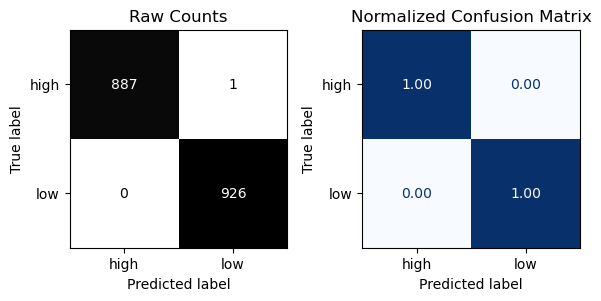


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.83      0.85      0.84       307
         low       0.84      0.82      0.83       298

    accuracy                           0.84       605
   macro avg       0.84      0.84      0.84       605
weighted avg       0.84      0.84      0.84       605



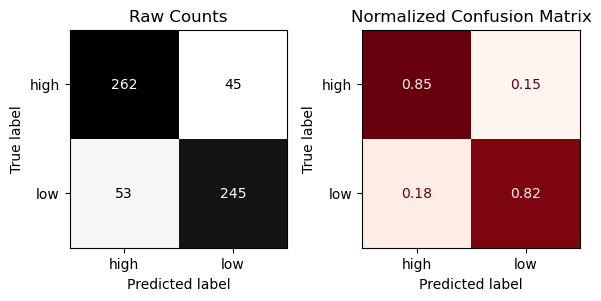

In [44]:
# evaluate model
evaluate_classification(clf_pipe, X_train,y_train, X_test, y_test)

#### In a Markdown cell, document your observations from your results. (e.g., how good is the model overall? Is it particularly good/bad at predicting one class?)

The model is about the same when it comes to predicting either class in the test data, hovering around .83/.84 f1-score with an accuracy of .84. It is possible it is overfitting as per the 1.0 scores on all metrics in the training data.

### GridSearch Text Vectorization

Attempt to improve your model by tuning the text preprocessing steps.

#### Construct a grid of parameters for the text vectorization step. Consider trying:

CountVectorizer/TfidfVectorizer

stopwords

ngram_range

min_df/max_df

In [67]:
# Define params to try
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    "vectorizer__min_df": [2,3,4],
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english'],
    "vectorizer__ngram_range": [(1, 1), (1, 2), (1,3)]
}

In [68]:
# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}

In [69]:
# Set up Pipeline to allow GridSearching
vect_pipe = Pipeline([('vectorizer', CountVectorizer()),
                     ('clf',RandomForestClassifier(random_state=42))])

#### Fit and evaluate the grid search results:

What were the best parameters?
How does the best estimator perform when evaluated on the training and test data?

In [70]:
%%time
# Create grid search
grid_search = GridSearchCV(vect_pipe, param_grid_shared, cv=2, scoring = 'accuracy', verbose=1, n_jobs=-1)

CPU times: total: 15.6 ms
Wall time: 476 µs


In [71]:
%%time
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 162 candidates, totalling 324 fits
CPU times: total: 10 s
Wall time: 4min 48s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'vectorizer__max_df': [0.7, 0.8, 0.9],
                         'vectorizer__max_features': [None, 1000, 2000],
                         'vectorizer__min_df': [2, 3, 4],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'vectorizer__stop_words': [None, 'english']},
             scoring='accuracy', verbose=1)

In [75]:
# what were the best params?
grid_search.best_params_

{'vectorizer__max_df': 0.7,
 'vectorizer__max_features': 1000,
 'vectorizer__min_df': 4,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__stop_words': 'english'}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       1.00      1.00      1.00       888
         low       1.00      1.00      1.00       926

    accuracy                           1.00      1814
   macro avg       1.00      1.00      1.00      1814
weighted avg       1.00      1.00      1.00      1814



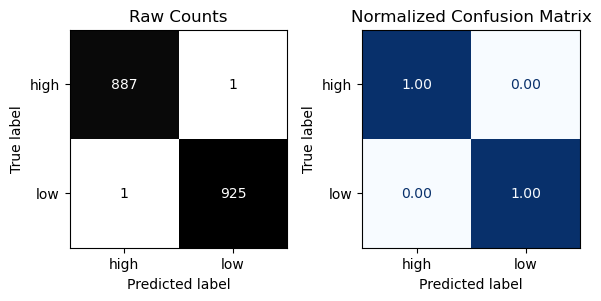


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.83      0.83      0.83       307
         low       0.82      0.82      0.82       298

    accuracy                           0.83       605
   macro avg       0.83      0.83      0.83       605
weighted avg       0.83      0.83      0.83       605



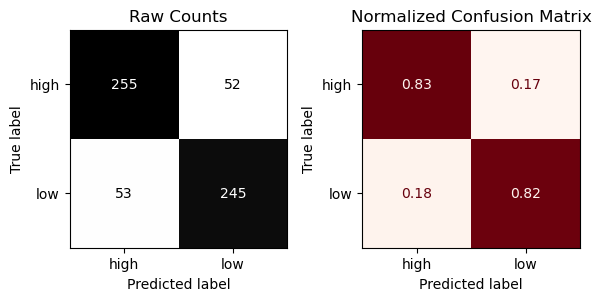

In [73]:
best_model = grid_search.best_estimator_

evaluate_classification(best_model,X_train,y_train,X_test,y_test)

###### How does the best estimator perform when evaluated on the training and test data?

The best estimator actually resulted in slightly lower scores

### Deep NLP (RNNs) (Use core-text-classification-rnn.ipynb and/or mock-exam part 1 to answer both below. )

For this part of the project, you will use a Keras TextVectorization layer as part of your RNN model. This serves the same purpose as using the sklearn pipeline: it bundles text preparation into the model, making it deployment-ready.

#### Create train/test/val datasets

    Convert the target categories to integers (e.g., Using sklearn's LabelEncoder)
    Create a tensorflow dataset using the X and (integer version) of y.
    Split the dataset into training, test, and validation datasets.

##### convert target categories to integers with LabelEncoder

In [83]:
# instantiate LabelEncoder
encoder = LabelEncoder()

In [84]:
# Fit and Transform the strings into integers
y = pd.Series(encoder.fit_transform(y))
y.value_counts()

1    1224
0    1195
dtype: int64

##### Create a tensorflow dataset using the X and (integer version) of y.

In [85]:
# Convert to Dataset object
ds = tf.data.Dataset.from_tensor_slices((X, y))
ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [86]:
# shuffle data once
ds = ds.shuffle(buffer_size=len(ds), reshuffle_each_iteration=False)

In [87]:
# Add a column to the dataframe that has the length of each paragraph
df['sequence_length'] = df['review'].map( lambda x: len(x.split(" ")))

In [88]:
# Use the maximum length as the sequence length
df['sequence_length'].describe()

count    2419.000000
mean      225.767673
std       270.815728
min         1.000000
25%        62.000000
50%       143.000000
75%       286.500000
max      4017.000000
Name: sequence_length, dtype: float64

In [89]:
# Use the maximum length as the sequence length
SEQUENCE_LENGTH = 4017

##### Split the dataset into training, test, and validation datasets.

In [90]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )

In [91]:
# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)

In [92]:
# Set the batch size
BATCH_SIZE =32

In [93]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)

# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)

# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

In [94]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

In [95]:
# Preview the text
ds_texts.take(1).get_single_element()

<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'If you enjoy reading my Spoiler-Free reviews, please follow my blog :)\r\n\r\nLiving in Portugal has a ton of pros, but regarding movies, it lacks serious advantages. The price of admission is expensive, there is only one film theater in my city (every time I want to watch a movie on IMAX or Dolby Atmos, it\'s a financial effort and time-consuming) and the worst of all, a whole bunch of films aren\'t released in their original date, especially November/December Oscar-bait movies. Only now I had the opportunity to see Green Book, and I am so mad I wasn\'t able to write its review in 2018 because this is undoubtedly the best comedy-drama of last year and one of the best overall!\r\n\r\nWith the help of a terrific cast, Peter Farrelly and his writing crew (which counts with Vallelonga\'s son, Nick) deliver what I think is the best screenplay of 2018. I can\'t remember the last time I cried of so much laughter in a film. I can\'t remem

#### Create a Keras Text Vectorization layer

    Create a Keras text vectorization layer for an RNN (sequence) model.
    Fit/Adapt the text vectorization layer on the training texts.
    Save the vocabulary size from the layer to use in your models' Embedding layer.

In [79]:
# Create keras text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

In [101]:
# # same as above cell. pick one.Define vectorizer layer. Use the custom function to build and fit the vectorizer before using it in model
# vectorizer, lookup = fn.make_text_vectorization_layer(train_ds, output_mode='int',output_sequence_length=SEQUENCE_LENGTH

In [96]:
# Fit/Adapt the text vectorization layer on the training texts.
sequence_vectorizer.adapt(ds_texts)

24994

In [97]:
# Save the vocabulary size from the layer to use in your models' Embedding layer.
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()

In [99]:
# unique classes
classes = y.unique()
classes

array([0, 1])

#### Build an RNN with the TextVectorization Layer

    Build and fit at least 1 sequence model (LSTM, GRU, Bidirectional, etc.)

    Evaluate the model on the training and test data.

        In a Markdown cell, document your observations from your results. (e.g., How did the RNN compare to your ML model? Was it superior to your ML model in some way (e.g., accuracy, recall, etc.)

In [102]:
def build_gru_model_bi_pool(text_vectorization_layer):
    
    gru_model_bi_pool = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                      output_dim=EMBED_DIM,
                      input_length=SEQUENCE_LENGTH)])
        
    # Add bidirectional component to GRU layer 
    gru_model_bi_pool.add(layers.Bidirectional(layers.GRU(64, return_sequences = True)))
    gru_model_bi_pool.add(layers.Dropout(.2))
    gru_model_bi_pool.add(layers.Bidirectional(layers.GRU(64, return_sequences = True)))
    # Add a pooling layer *new
    gru_model_bi_pool.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    gru_model_bi_pool.add(layers.Dense(len(classes), activation='softmax'))
                     
    optimizer = optimizers.legacy.Adam()
    gru_model_bi_pool.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model_bi_pool.summary()
    return gru_model_bi_pool
    
#Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding_6 (Embedding)     (None, 100, 100)          2499400   
                                                                 
 bidirectional_12 (Bidirecti  (None, 100, 128)         63744     
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 100, 128)          0         
                                                                 
 bidirectional_13 (Bidirecti  (None, 100, 128)         74496     
 onal)                                                           
                                                      

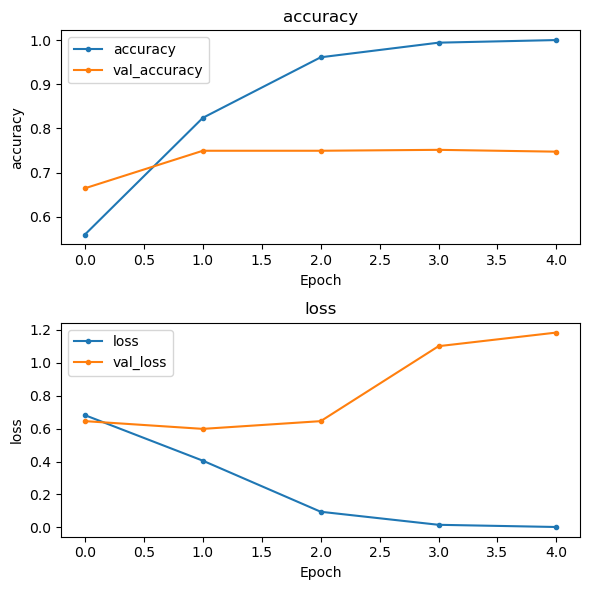


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       823
           1       1.00      1.00      1.00       870

    accuracy                           1.00      1693
   macro avg       1.00      1.00      1.00      1693
weighted avg       1.00      1.00      1.00      1693



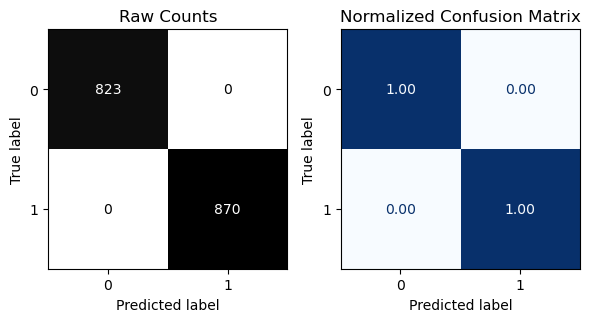


- Evaluating Training Data:
53/53 [==============================] - 3s 64ms/step - loss: 8.7351e-04 - accuracy: 1.0000
{'loss': 0.0008735095034353435, 'accuracy': 1.0}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.82      0.77       126
           1       0.77      0.67      0.72       117

    accuracy                           0.74       243
   macro avg       0.75      0.74      0.74       243
weighted avg       0.75      0.74      0.74       243



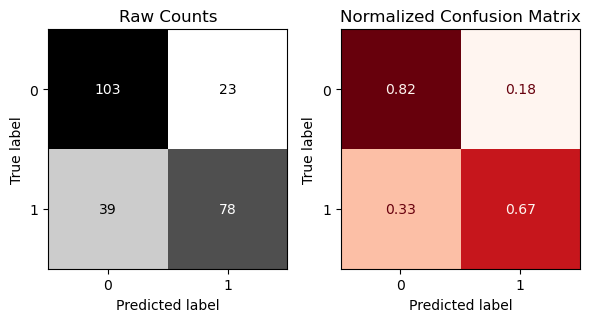


- Evaluating Test Data:
8/8 [==============================] - 1s 64ms/step - loss: 1.2198 - accuracy: 0.7449
{'loss': 1.2198446989059448, 'accuracy': 0.7448559403419495}


In [120]:
EMBED_DIM = 100
#Build the model
model = build_gru_model_bi_pool(sequence_vectorizer)
# Fit the model
EPOCHS = 5#30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Evaluate the model
results = evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);

The model appears to be overfit due to the high scores on training data and low scores on test data. The RNN performed lower than the ML model.